# Introduction

This demo functions allow users to remotely access and load a specific resolution level (pyramid series) from a large OME-TIFF<br>
image file—without downloading the entire file. It uses smart streaming tools to efficiently retrieve just the image data needed,<br>
making it ideal for working with massive microscopy datasets. The images are hosted on a remote server, and the demo provides a user <br>
interface to select the desired resolution level.<br>

The images can be associated with segmentation data, e.g., cells, which can be visualized alongside the image.<br>
We show how to display cells on the image, and then apply affine transformations to the cells<br>
to overlay them on the Xenium coordinates.<br>

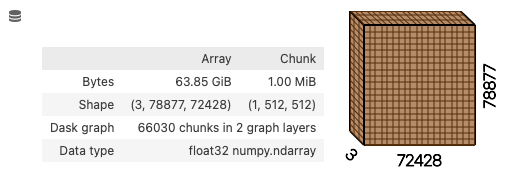

## Import python libraries

In [ ]:
import requests
import tifffile
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import fsspec
import zarr
import xarray as xr
from kerchunk.tiff import tiff_to_zarr

def read_ome_tiff_series(url: str, series_index: int = 0):
    """
    Reads a specific pyramid series from a remote OME-TIFF file using fsspec + kerchunk + zarr.

    Parameters:
        url (str): URL to the remote OME-TIFF file.
        series_index (int): Index of the pyramid level to read (0 = highest resolution).

    Returns:
        xarray.DataArray: The image data for the specified pyramid level.
    """
    # Generate kerchunk reference directly from URL
    ref = tiff_to_zarr(url)

    # Create a mapper from the reference
    fs = fsspec.filesystem("reference", fo=ref)
    mapper = fs.get_mapper("")

    # Open the dataset
    ds = xr.open_zarr(mapper, consolidated=False)

    # Access the requested series
    level_key = str(series_index)
    if level_key not in ds:
        raise ValueError(f"Series index {series_index} not found. Available keys: {list(ds.keys())}")

    return ds[level_key]

## Connect to remote storage and inspect the image structure

In [ ]:
url = "https://assets.api.sennetconsortium.org/49dad6221c05a563a075b2bf564be2f1/ometiff-pyramids/lab_processed/images/Image_0017272.ome.tif?token="

imgFull = read_ome_tiff_series(url, series_index=0)
imgFull

## Load a small region in full resolution

The entire image is large, about 12 GB. Downloading the entire image may take a while depending on the network connection.
In addition, the downloaded image will take significant space on the computer.

<br>
We load a small region, e.g., 2000 by 2000 pixels, that can be viewed right away.
The pixels values is only loaded by accession ".values" after slicing the Xarray.

In [ ]:
x1, y1 = 43000, 55000
dx, dy = 2000, 2000
x2, y2 = x1 + dx, y1 + dy
imgFullROI = imgFull[:, y1:y2, x1:x2].values.astype(np.uint8)
plt.imshow(np.moveaxis(imgFullROI, 0, -1), extent=(x1, x2, y1, y2))
plt.title("Full Resolution ROI")
ax = plt.gca()
ax.set_xlabel("X, pixels")
ax.set_ylabel("Y, pixels")
plt.xticks(rotation=15)
plt.show()

## Download a downsampled version of the image, from the same URL

In [ ]:
# Connect to remote storage downsampled series, e.g. series 3
imgConnector = read_ome_tiff_series(url, series_index=3)
print(imgConnector.shape)

# Load the downsampled series by converting to numpy array
img = imgConnector.values.astype(np.uint8)

## Display the downsampled image and arbitrary cells as "x" markers

In [ ]:
# Even the downsampled image may be too large to display in full resolution,
# so we will downsample it further for plots
f = 2  # Further downsampling factor
plt.imshow(np.moveaxis(img[:, ::f, ::f], 0, -1), extent=(0, imgFull.shape[2], imgFull.shape[1], 0))
ax = plt.gca()
ax.set_xlabel('X, pixels')
ax.set_ylabel('Y, pixels')
plt.xticks(rotation=15)

# Make up some H&E cell coordinates for demonstration, in the full resolution coordinates
# These could represent coordinates of cells detected in the H&E image
h_and_e_cells = np.array([[11000, 16000],
                          [16000, 34000],
                          [1500, 48000]])

# Display cells with "x" markers
ax.scatter(h_and_e_cells[:, 0],
            h_and_e_cells[:, 1],
            marker='x', c='lime', s=25);

plt.show()

## Transfer the cells coordinates to Xenium coordinates

In [ ]:
# Use the pre-computed affine transformation matrix
# The mattrices can be found in the "extras" or "transformation" directory of each the repository whenever available.
M = np.array([[1.786119779961643740e-03,6.443031167854157415e-01],
            [-6.443483716831650554e-01,1.235765492824911086e-03]])
Tr = np.array([4.039155169888560408e+02, 4.698404373738830327e+04])
print(M)
print(Tr)

mpp_Xe = 0.2125

### Download demo Xenium dataset and load it into memory

In [ ]:
# dataPath = './'
dataPath = '/projects/activities/kappsen-tmc/USERS/domans/examples-sennet-portal/'

In [ ]:
!curl -L "https://zenodo.org/api/records/15777586/files-archive" -o dataset.zip && unzip dataset.zip && rm dataset.zip

In [ ]:
import pandas as pd

def load_xenium_dataset(id, path, N=None, suffix=None, f=1.):

    """Load a Xenium dataset from a specified Xenium bundle directory.

    Parameters
    ----------
    id : str
        Identifier for the sample (not used internally).
    path : str
        Path to the Xenium bundle directory. This directory should contain
        'cells.parquet' and 'cell_feature_matrix.h5' files.
    N : int, optional
        Number of cells to randomly sample. If None, use all cells.
    suffix : str, optional
        Suffix to append to cell indices.
    f : float, optional
        Scaling factor for spatial coordinates (default is 1.0).

    Returns
    -------
    adata : AnnData
        Data object with spatial coordinates in `adata.obsm['spatial']`.
    """

    obs = pd.read_parquet(path + '/cells.parquet', engine='auto', columns=None,
                          storage_options=None, use_nullable_dtypes=False).set_index('cell_id')
    adata = sc.read_10x_h5(path + '/cell_feature_matrix.h5')
    if not N is None:
        adata = adata[adata.obs.sample(N).index]
    adata.obs = obs.loc[adata.obs.index]
    if not suffix is None:
        adata.obs.index = adata.obs.index + suffix
    adata.obsm['spatial'] = (adata.obs[['x_centroid', 'y_centroid']]*f).astype(int).values

    return adata

id = 'JDC-WP-012-w'
ad = load_xenium_dataset(id, dataPath + '/JDC-WP-012-w-xenium-slim/', suffix='.' + id)

## Plot the Xenium cells and the H&E cells via affine transformation

In [ ]:
plt.scatter(ad.obs['x_centroid'], ad.obs['y_centroid'], s=0.1, alpha=0.05, c='steelblue')
ax = plt.gca()
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')

xe_cells_coords = (np.dot(h_and_e_cells, M.T) + Tr) * mpp_Xe
plt.scatter(xe_cells_coords[:, 0], xe_cells_coords[:, 1], marker='x', c='crimson', s=100);
plt.show()